In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import

In [ ]:
# !pip install deeplake
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=e799d4c375c017756772a241fc38aad5902feb0385eb4ee794d9bf2033bd08d9
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=cebea7b29bfd7deaca765d5aceae614e50f4b6e9120fddeb92b367219fec73b2
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [ ]:
import logging
import torch, torchvision
import pickle
import time
import os
import random
import warnings
# import deeplake
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from fvcore.nn import FlopCountAnalysis
from torchvision.transforms import v2
import time
from IPython.display import clear_output
from drive.MyDrive.GreenEdge.Pretrained.utils import EarlyExitCustomNet64, CreateDataset, EarlyExitCustomNet128

#Hide warnings
logging.basicConfig(filename='app.log',
    level=logging.CRITICAL,
    force=True,
)

In [ ]:
path = "/content/drive/MyDrive/GreenEdge/Pretrained"
data_path = "/content/drive/MyDrive/GreenEdge/"

batches_size = 256

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device:", device)

Device: cuda


## Dataset definition

In [ ]:
# Create dataset and dataloader

validation_dataset_64 = CreateDataset(augmentation = True, train = True, data_path = data_path)
# validation_dataset_128 = CreateDataset(augmentation = True, train = True, data_path = data_path, resize = 128)

val_dataloader_64 = DataLoader(validation_dataset_64, batch_size=batches_size,
                        shuffle=False, num_workers=0)
# val_dataloader_128 = DataLoader(validation_dataset_128, batch_size=batches_size,
#                         shuffle=False, num_workers=0)

## Model Test

In [ ]:
model_50 = path + "/models/resnet50earlycutmix_model.torch"
model_50X = path + "/models/resnext50earlycutmix_64_model.torch"
# model_50_128 = path + "/Resize/ResNet50_128_parameters.torch"
# model_50X_128 = path + "/Resize/ResNeXt50_128_parameters.torch"

In [ ]:
Threshold = np.linspace(0,7, 11)

In [ ]:
# Loading the models with different entropy threshold
models = []
weights = []
for T in Threshold:
  models.append(EarlyExitCustomNet64(device,resnext = False,T=T))
  weights.append(torch.load(model_50))
  # models.append(EarlyExitCustomNet128(device,T=T))
  # weights.append(torch.load(model_50X_128))
  models.append(EarlyExitCustomNet64(device,T=T))
  weights.append(torch.load(model_50X))
  # models.append(EarlyExitCustomNet128( device, resnext = False, T=T))
  # weights.append(torch.load(model_50_128))

<ipython-input-8-73f8fbfdabd8>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights.append(torch.load(model_50))
<ipython-input-8-73f8fbfdabd8>:10: FutureWarning: You ar

In [ ]:
acc = []
flop = []
for j, (model, weight) in enumerate(zip(models, weights)):
        print( f"################# {j} ###############")
        model.load_state_dict(weight)
        model.to(device)
        model.eval()

        start = time.time()
        total =  0
        total_flops = 0
        correct = 0

        y_true=[]
        y_pred=[]

        # hist=[]

        val_dataloader = val_dataloader_64 #if j % 2 == 0 else val_dataloader_128
        with torch.no_grad():
            for i, data in enumerate(val_dataloader):

                # print(f"BATCH {i}")

                inputs = data['images']
                inputs = inputs.to(device)


                labels = torch.squeeze(data['labels'])
        #         labels = torch.LongTensor([labels_map[label.item()] for label in labels])
                labels = labels.to(device)


                #outputs = model(inputs.float())
                #outputs.to(device)

                predicted = model(inputs.float())

                #_, predicted = torch.max(outputs.data, 1)

                y_pred.append(predicted)
                y_true.append(labels)

                # Compute FLOPs
                flops = FlopCountAnalysis(model, inputs).tracer_warnings(mode='none')
                total_flops += flops.total()/10**9 # in Giga Flops

                print(f"FLOPS {flops.total()}")

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                #loss = loss_fn(outputs, labels)
                #loss = loss_fn(predicted, labels)
                #loss_batch = loss.detach().cpu().numpy()


            energy = total_flops / total
            test_acc = 100 * correct / total

            acc.append(test_acc)
            flop.append(energy)

        end = time.time()
        print(f"################### Time: {end-start} ######################")


Output streaming troncato alle ultime 5000 righe.
FLOPS 132825489408
FLOPS 100125540352
FLOPS 76039438336
FLOPS 96102014976
FLOPS 103787356160
FLOPS 133961924608
FLOPS 135679369216
FLOPS 98958737408
FLOPS 79515164672
FLOPS 93631684608
FLOPS 99988815872
FLOPS 118958637056
FLOPS 117649424384
FLOPS 90035388416
FLOPS 86677389312
FLOPS 131349184512
FLOPS 134586613760
FLOPS 94083596288
FLOPS 92653813760
FLOPS 131023527936
FLOPS 138259800064
FLOPS 138854121472
FLOPS 133546065920
FLOPS 101363548160
FLOPS 98364416000
FLOPS 108147908608
FLOPS 108646342656
FLOPS 113094254592
FLOPS 116356366336
FLOPS 107887771648
FLOPS 118235217920
FLOPS 135558799360
FLOPS 132181803008
FLOPS 131067207680
FLOPS 116170276864
FLOPS 98038759424
FLOPS 93346865152
FLOPS 92727861248
FLOPS 104458567680
FLOPS 117671264256
FLOPS 130448203776
FLOPS 138251272192
FLOPS 131543801856
FLOPS 112026181632
FLOPS 98457460736
FLOPS 91056939008
FLOPS 108380520448
FLOPS 116972527616
FLOPS 109029892096
FLOPS 108104228864
FLOPS 1137161011

In [ ]:
print(acc)
print(flop)

[91.439, 87.242, 91.483, 87.201, 90.769, 86.679, 88.71, 84.677, 84.153, 80.184, 76.605, 70.962, 69.591, 59.917, 68.885, 58.226, 69.217, 58.209, 68.99, 58.306, 69.146, 58.462]
[0.6232760320000049, 0.6353469439999969, 0.5509481371648002, 0.58939660115968, 0.4911502452736001, 0.5433320809267197, 0.4346228992000005, 0.49223339220992063, 0.37512414597120003, 0.4302773958246397, 0.31004249907200004, 0.3467559808204801, 0.2617201606656005, 0.2657943897702401, 0.2571960319999994, 0.2546401280000012, 0.2571960319999994, 0.2546401280000012, 0.2571960319999994, 0.2546401280000012, 0.2571960319999994, 0.2546401280000012]


In [ ]:
# flop = [0.6232760319999998, 2.5401589760000003, 0.6353469439999995, 2.491875328000002, 0.5795743211520001, 2.4431966814208, 0.6015775629311999, 2.3948810321920004, 0.5353370767359998, 2.3172579475456, 0.5642347585536002, 2.2866118901759998, 0.48407488716800007, 2.1454147485696002, 0.5175347339264, 2.1338980351999988, 0.41783760895999983, 1.9010422865919998, 0.45417077473280015, 1.9071922339839995, 0.330092969984, 1.5398051954688001, 0.35772901621760006, 1.5627843665920003, 0.2631927255040001, 1.1088128688127998, 0.266657255424, 1.151292964864, 0.2571960320000001, 1.0185605120000003, 0.2546401280000001, 1.0287841280000003, 0.2571960320000001, 1.0185605120000003, 0.2546401280000001, 1.0287841280000003, 0.2571960320000001, 1.0185605120000003, 0.2546401280000001, 1.0287841280000003, 0.2571960320000001, 1.0185605120000003, 0.2546401280000001]
# acc = [71.59, 82.02, 72.0, 79.92, 71.49, 81.86, 71.87, 79.86, 70.29, 80.67, 70.96, 78.86, 67.0, 77.2, 68.45, 75.77, 61.08, 69.8, 63.48, 68.13, 51.83, 56.1, 54.18, 54.33, 43.89, 38.77, 43.57, 38.14, 43.26, 35.44, 42.33, 33.49, 43.26, 35.44, 42.33, 33.49, 43.26, 35.44, 42.33, 33.49, 43.26, 35.44, 42.33]
# print(acc)
# print(flop)
# flop = [1/i for i in flop]

[71.59, 82.02, 72.0, 79.92, 71.49, 81.86, 71.87, 79.86, 70.29, 80.67, 70.96, 78.86, 67.0, 77.2, 68.45, 75.77, 61.08, 69.8, 63.48, 68.13, 51.83, 56.1, 54.18, 54.33, 43.89, 38.77, 43.57, 38.14, 43.26, 35.44, 42.33, 33.49, 43.26, 35.44, 42.33, 33.49, 43.26, 35.44, 42.33, 33.49, 43.26, 35.44, 42.33]
[0.6232760319999998, 2.5401589760000003, 0.6353469439999995, 2.491875328000002, 0.5795743211520001, 2.4431966814208, 0.6015775629311999, 2.3948810321920004, 0.5353370767359998, 2.3172579475456, 0.5642347585536002, 2.2866118901759998, 0.48407488716800007, 2.1454147485696002, 0.5175347339264, 2.1338980351999988, 0.41783760895999983, 1.9010422865919998, 0.45417077473280015, 1.9071922339839995, 0.330092969984, 1.5398051954688001, 0.35772901621760006, 1.5627843665920003, 0.2631927255040001, 1.1088128688127998, 0.266657255424, 1.151292964864, 0.2571960320000001, 1.0185605120000003, 0.2546401280000001, 1.0287841280000003, 0.2571960320000001, 1.0185605120000003, 0.2546401280000001, 1.0287841280000003, 

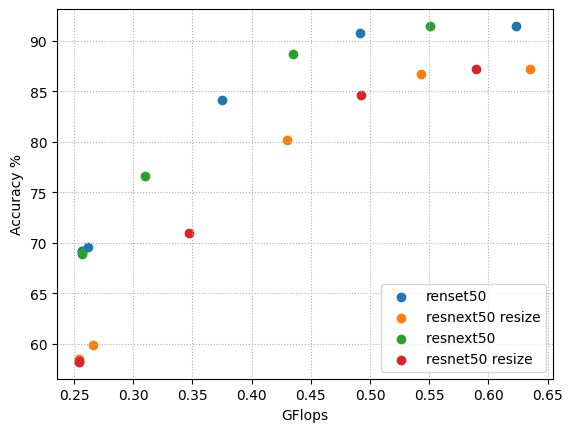

In [ ]:
plt.scatter(flop[0::4],acc[0::4], label = "renset50")
plt.scatter(flop[1::4],acc[1::4],label = "resnext50 resize")
plt.scatter(flop[2::4],acc[2::4],label = "resnext50 ")
plt.scatter(flop[3::4],acc[3::4], label = "resnet50 resize")
plt.legend()
plt.xlabel("GFlops")
plt.ylabel("Accuracy %")
plt.grid(linestyle=':')


# for i, txt in enumerate(np.linspace(1,7, 30)[0:3]):
#     plt.annotate(f"T{i}: {txt:.2f}", (flop[i], acc[i]))

In [ ]:
# flop_50, acc_50 = flop[0::4][0:7],acc[0::4][0:7]
flop_50X_128, acc_50X_128 = flop[1::4][0:4],acc[1::4][0:4]
flop_50_128, acc_50_128 = flop[3::4][2:2],acc[3::4][2:2]
flop_50X, acc_50X = flop[2::4][0:7],acc[2::4][0:7]

flop_ordered = flop_50X_128 + flop_50_128 + flop_50X
acc_ordered = acc_50X_128 + acc_50_128 + acc_50X


print(len(acc_ordered), len(flop_ordered))
metric_score1 = print(metric2(flop_ordered,acc_ordered)/100)

acc_ordered = [max(acc_ordered)] + acc_ordered
flop_ordered = [0] + flop_ordered
print(len(acc_ordered), len(flop_ordered))

11 11
2.3376978073006365
12 12


In [ ]:
# In this cell you can find the values that we selected to submit for the challenge and below the graph accuracy vs flops.

# flop_ordered = [2.5401589760000003, 2.4431966814208, 2.3172579475456, 2.1454147485696002, 0.6353469439999995, 0.6015775629311999, 0.5642347585536002, 0.5175347339264, 0.45417077473280015, 0.35772901621760006, 0.266657255424]
# acc_ordered = [82.02, 81.86, 80.67, 77.2, 72.0, 71.87, 70.96, 68.45, 63.48, 54.18, 43.57]
# print(flop_ordered)
# print(acc_ordered)

In [ ]:
metric2([1/0.01, 1/0.39, 1/0.69, 1/1.09, 1/1.83, 1/4.39, 1/10.27, 1/19.07, 1/37.75],[0.05, .77692, .78642, .80608, .82008, .83384, .83444, .84008, .84122])

6.906871292422957

In [ ]:
acc_to_plot = [i/100 for i in acc_ordered]

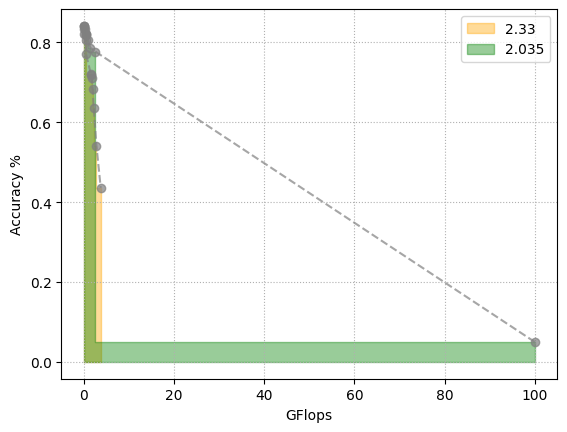

In [ ]:
# import matplotlib.pyplot as plt

# plt.scatter(flop_ordered, acc_ordered, label = f"Area = 31.78")
plt.plot(flop_ordered, acc_to_plot, 'o--', color='grey', alpha=0.7)
plt.fill_between(flop_ordered, acc_to_plot, step="pre", alpha=0.4, label=f'{round(2.33,3)}' , color = "orange")

efficientnet_accuracies = [0.05,.77692, .78642, .80608, .82008, .83384, .83444, .84008, .84122, .84122]
efficientnet_flops = [0.01 , 0.39, 0.69, 1.09, 1.83, 4.39, 10.27, 19.07, 37.75, 1e30]
efficientnet_flops = [1/i for i in efficientnet_flops ]
plt.plot(efficientnet_flops, efficientnet_accuracies, 'o--', color='grey', alpha=0.7)
plt.fill_between(efficientnet_flops, efficientnet_accuracies, step="post", alpha=0.4, label=f'{round(2.035,3)}' , color = "green")
# plt.xlabel("GFlops")
# plt.ylabel("Accuracy %")
# plt.grid(linestyle=':')
# plt.legend()


plt.xlabel("GFlops")
plt.ylabel("Accuracy %")
plt.grid(linestyle=':')



plt.legend()

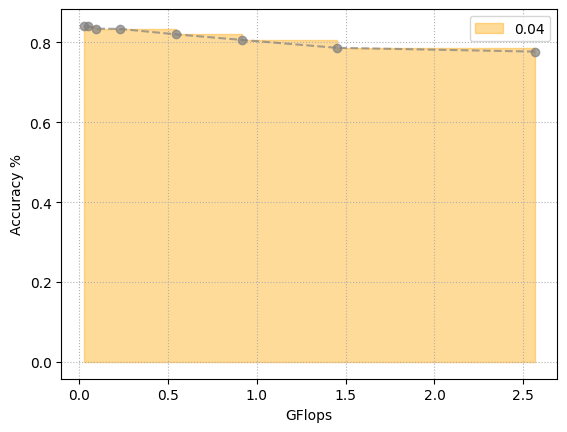

In [ ]:
efficientnet_accuracies = [.77692, .78642, .80608, .82008, .83384, .83444, .84008, .84122]
efficientnet_flops = [0.39, 0.69, 1.09, 1.83, 4.39, 10.27, 19.07, 37.75]
efficientnet_flops = [1/i for i in efficientnet_flops ]
plt.plot(efficientnet_flops, efficientnet_accuracies, 'o--', color='grey', alpha=0.7)
plt.fill_between(efficientnet_flops, efficientnet_accuracies, step="pre", alpha=0.4, label=f'{round(metric2(efficientnet_flops,efficientnet_accuracies)/100,3)}' , color = "orange")
plt.xlabel("GFlops")
plt.ylabel("Accuracy %")
plt.grid(linestyle=':')
plt.legend()

In [ ]:
def metric(Ens, Accs):
    e_max = 39.32
    AUC = 0
    Ens, Accs = zip(*sorted(zip(Ens, Accs)))
    Ens, Accs = list(Ens),list(Accs)
    # Ens.append(e_max)
    for i in range(len(Ens)-1):
      AUC = AUC + Accs[i] * (Ens[i+1]-Ens[i])
    return AUC

In [ ]:
print(metric(flop_ordered,acc_ordered)/100)

31.782595714999253


In [ ]:
print(metric(flop[0::4] + flop[2::4] ,acc[0::4] + acc[2::4] )/100)

0.30727633129533516


In [ ]:
31.782136448054885

In [ ]:
def metric2(Ens, Accs):
  Ens, Accs = zip(*sorted(zip(Ens, Accs)))
  Ens, Accs = list(Ens),list(Accs)
  # print(Ens)
  # print(Accs)
  AUC = 0
  for i in range(1,len(Ens)):
    AUC = AUC + Accs[i] * (Ens[i]-Ens[i-1])
  return AUC

In [ ]:
metric2(efficientnet_flops,efficientnet_accuracies)/100

[9.999999999999999e-31, 0.026490066225165563, 0.05243838489774515, 0.09737098344693282, 0.22779043280182235, 0.5464480874316939, 0.9174311926605504, 1.4492753623188408, 2.564102564102564]
[0.84122, 0.84122, 0.84008, 0.83444, 0.83384, 0.82008, 0.80608, 0.78642, 0.77692]


0.020350764206280843

In [ ]:
print(metric2(flop_ordered,acc_ordered)/100)

[0, 0.3936761476144712, 0.4092998355819912, 0.43154453351176675, 0.4661103409803275, 1.5739431966166832, 1.6622960389803736, 1.77231194080186, 1.932237460495188, 2.201814946345512, 2.795412042817679, 3.750132350270927]
[0.8201999999999999, 0.8201999999999999, 0.8186, 0.8067, 0.772, 0.72, 0.7187, 0.7095999999999999, 0.6845, 0.6347999999999999, 0.5418, 0.4357]
0.023376978073006364


# Test new metric

In [ ]:
def metric3(Ens, Accs):


  Ens = [1/(i+1) for i in Ens]
  Ens, Accs = zip(*sorted(zip(Ens, Accs)))
  Ens, Accs = list(Ens),list(Accs)

  AUC = [0]
  for i in range(len(Ens)):
    AUC.append(AUC[-1] + Accs[i] * Ens[i])

  Ens = [0] + Ens

  return AUC, Ens



def metric4(Ens, Accs):

  Ens = [1/(i+1) for i in Ens]

  Ens = [0] + Ens
  Accs = [max(Accs)]+Accs

  Ens, Accs = zip(*sorted(zip(Ens, Accs)))
  Ens, Accs = list(Ens),list(Accs)



  print(Ens)
  print(Accs)

  AUC = 0
  for i in range(1, len(Ens)):
    AUC = AUC + Accs[i] * (Ens[i]-Ens[i-1])

  return AUC, Ens, Accs


def metric5(Ens, Accs):

  Ens = [1/(np.log(i+1)+1) for i in Ens]

  Ens = [0] + Ens
  Accs = [max(Accs)]+Accs

  Ens, Accs = zip(*sorted(zip(Ens, Accs)))
  Ens, Accs = list(Ens),list(Accs)



  print(Ens)
  print(Accs)

  AUC = 0
  for i in range(1, len(Ens)):
    AUC = AUC + Accs[i] * (Ens[i]-Ens[i-1])

  return AUC, Ens, Accs

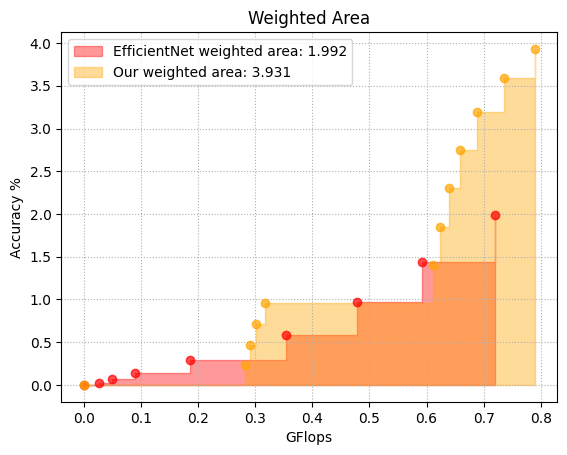

In [ ]:
efficientnet_accuracies = [.77692, .78642, .80608, .82008, .83384, .83444, .84008, .84122]
efficientnet_flops = [ 0.39, 0.69, 1.09, 1.83, 4.39, 10.27, 19.07, 37.75]

flop_ordered = [2.5401589760000003, 2.4431966814208, 2.3172579475456, 2.1454147485696002, 0.6353469439999995, 0.6015775629311999, 0.5642347585536002, 0.5175347339264, 0.45417077473280015, 0.35772901621760006, 0.266657255424]
acc_ordered = [82.02, 81.86, 80.67, 77.2, 72.0, 71.87, 70.96, 68.45, 63.48, 54.18, 43.57]
acc_ordered = [i/100 for i in acc_ordered]


AUC, Ens = metric3(efficientnet_flops, efficientnet_accuracies)
AUC_1, Ens_1 = metric3(flop_ordered, acc_ordered)


plt.plot(Ens, AUC, 'o', color='red', alpha=0.7)
plt.fill_between(Ens, AUC, step="post", alpha=0.4, label=f'EfficientNet weighted area: {round(AUC[-1],3)}' , color = "red")

plt.plot(Ens_1, AUC_1, 'o', color='orange', alpha=0.7)
plt.fill_between(Ens_1, AUC_1, step="post", alpha=0.4, label=f'Our weighted area: {round(AUC_1[-1],3)}' , color = "orange")

plt.title("Weighted Area")
plt.xlabel("GFlops")
plt.ylabel("Accuracy %")
plt.grid(linestyle=':')
plt.legend()

[0, 0.025806451612903226, 0.04982561036372696, 0.08873114463176575, 0.1855287569573284, 0.35335689045936397, 0.47846889952153115, 0.591715976331361, 0.7194244604316546]
[0.84122, 0.84122, 0.84008, 0.83444, 0.83384, 0.82008, 0.80608, 0.78642, 0.77692]
[0, 0.2824731902661311, 0.2904277892099269, 0.3014537958194925, 0.3179230975675806, 0.611491037830808, 0.6243843714754623, 0.6392902309143604, 0.6589635002374185, 0.6876771403852118, 0.7365239956245675, 0.7894795499870726]
[0.8201999999999999, 0.8201999999999999, 0.8186, 0.8067, 0.772, 0.72, 0.7187, 0.7095999999999999, 0.6845, 0.6347999999999999, 0.5418, 0.4357]


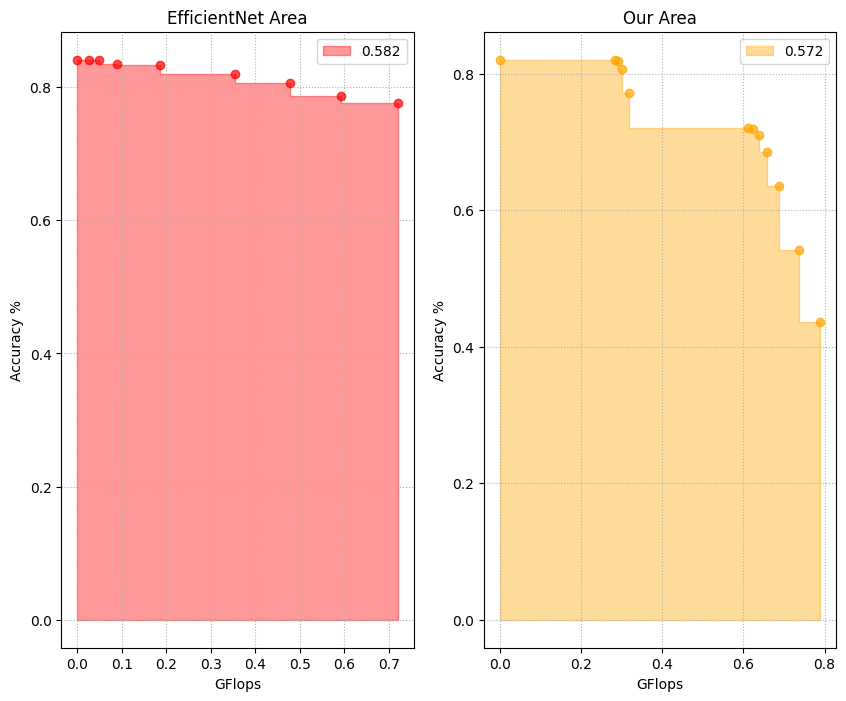

In [ ]:
efficientnet_accuracies = [.77692, .78642, .80608, .82008, .83384, .83444, .84008, .84122]
efficientnet_flops = [ 0.39, 0.69, 1.09, 1.83, 4.39, 10.27, 19.07, 37.75]

flop_ordered = [2.5401589760000003, 2.4431966814208, 2.3172579475456, 2.1454147485696002, 0.6353469439999995, 0.6015775629311999, 0.5642347585536002, 0.5175347339264, 0.45417077473280015, 0.35772901621760006, 0.266657255424]
acc_ordered = [82.02, 81.86, 80.67, 77.2, 72.0, 71.87, 70.96, 68.45, 63.48, 54.18, 43.57]
acc_ordered = [i/100 for i in acc_ordered]


AUC, Ens, Accs = metric4(efficientnet_flops, efficientnet_accuracies)
AUC_1, Ens_1, Accs_1 = metric4(flop_ordered, acc_ordered)


fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].set_title("EfficientNet Area")
ax[0].plot(Ens, Accs, 'o', color='red', alpha=0.7)
ax[0].fill_between(Ens, Accs, step="pre", alpha=0.4, label=f'{round(AUC,3)}' , color = "red")

ax[0].set_xlabel("GFlops")
ax[0].set_ylabel("Accuracy %")
ax[0].grid(linestyle=':')
ax[0].legend()


ax[1].plot(Ens_1, Accs_1, 'o', color='orange', alpha=0.7)
ax[1].fill_between(Ens_1, Accs_1, step="pre", alpha=0.4, label=f'{round(AUC_1,3)}' , color = "orange")

ax[1].set_title("Our Area")
ax[1].set_xlabel("GFlops")
ax[1].set_ylabel("Accuracy %")
ax[1].grid(linestyle=':')
ax[1].legend()

[0, 0.21472448433077304, 0.25004837418292003, 0.2922144433836097, 0.3725025494510173, 0.49012959579819143, 0.5756508665966162, 0.6558544560706139, 0.7522735132203952]
[0.84122, 0.84122, 0.84008, 0.83444, 0.83384, 0.82008, 0.80608, 0.78642, 0.77692]
[0, 0.44166263047960475, 0.4471471393291813, 0.45472351554033436, 0.46599500324726584, 0.6703064395693801, 0.6798146812813969, 0.6908955766779615, 0.7056729095853185, 0.7275712569623629, 0.7658061647702347, 0.808811942634127]
[0.8201999999999999, 0.8201999999999999, 0.8186, 0.8067, 0.772, 0.72, 0.7187, 0.7095999999999999, 0.6845, 0.6347999999999999, 0.5418, 0.4357]


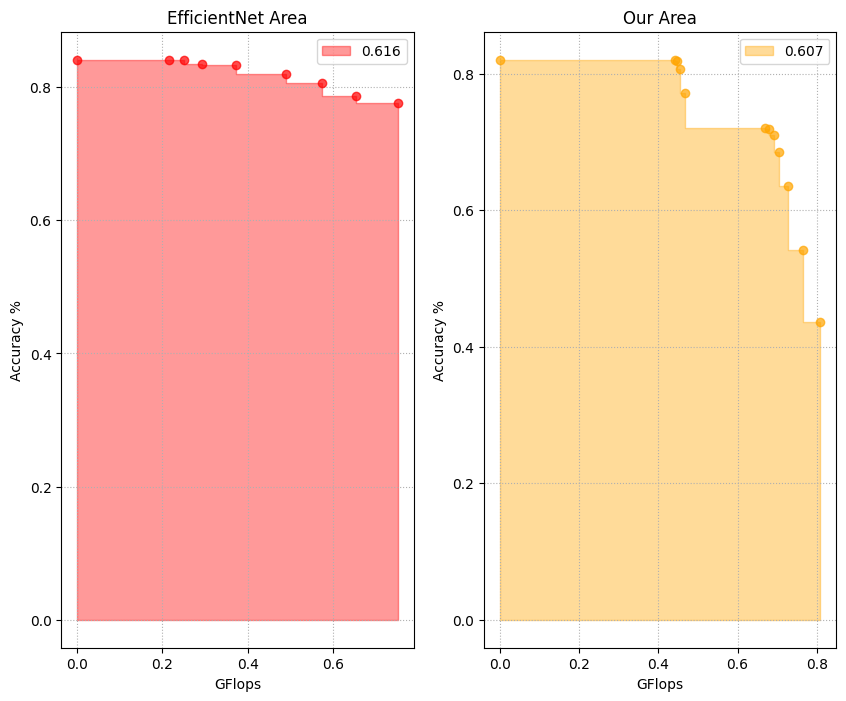

In [ ]:
efficientnet_accuracies = [.77692, .78642, .80608, .82008, .83384, .83444, .84008, .84122]
efficientnet_flops = [ 0.39, 0.69, 1.09, 1.83, 4.39, 10.27, 19.07, 37.75]

flop_ordered = [2.5401589760000003, 2.4431966814208, 2.3172579475456, 2.1454147485696002, 0.6353469439999995, 0.6015775629311999, 0.5642347585536002, 0.5175347339264, 0.45417077473280015, 0.35772901621760006, 0.266657255424]
acc_ordered = [82.02, 81.86, 80.67, 77.2, 72.0, 71.87, 70.96, 68.45, 63.48, 54.18, 43.57]
acc_ordered = [i/100 for i in acc_ordered]


AUC, Ens, Accs = metric5(efficientnet_flops, efficientnet_accuracies)
AUC_1, Ens_1, Accs_1 = metric5(flop_ordered, acc_ordered)


fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].set_title("EfficientNet Area")
ax[0].plot(Ens, Accs, 'o', color='red', alpha=0.7)
ax[0].fill_between(Ens, Accs, step="pre", alpha=0.4, label=f'{round(AUC,3)}' , color = "red")

ax[0].set_xlabel("GFlops")
ax[0].set_ylabel("Accuracy %")
ax[0].grid(linestyle=':')
ax[0].legend()


ax[1].plot(Ens_1, Accs_1, 'o', color='orange', alpha=0.7)
ax[1].fill_between(Ens_1, Accs_1, step="pre", alpha=0.4, label=f'{round(AUC_1,3)}' , color = "orange")

ax[1].set_title("Our Area")
ax[1].set_xlabel("GFlops")
ax[1].set_ylabel("Accuracy %")
ax[1].grid(linestyle=':')
ax[1].legend()